Example 2: Clustering RdRps
=============================

In [2]:
import numpy as np
import itertools as it
import multiprocess
import matplotlib.pyplot as plt
import time
from umap.umap_ import UMAP

from GWProt.GW_protein import *
from GWProt.GW_protein_pI import *

/home/elijah/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/elijah/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/elijah/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th


Riboviruses are a realm of viruses which include many human pathogens. They all have an essential RNA-dependent RNA-polymerase (RdRp) which is key to their replication machinery, has a high mutation rate, and often very low sequence homology; thus structural comparison can be key to identification and classification. In our benchmarking of GWProt, we used a dataset of 4,615 computationally determined (AlphaFold3) structures of viral RNA-dependent RNA polymerases (RdRp) as well as 512 non-RdRp “decoy” proteins, which were selected as non-viral homologs. For our testing we used taxonomical annotations retrieved from Entrez, with 5 phyla of riboviruses.

Here we display a UMAP clustering of the different phyla and decoys:


![UMAP Clustering](GWRdRpclustering.PNG)

In this tutorial we use a subset consisting of 50 randomly chosen RdRps from the phyla XXXX and XXXX.
We will run different variants of Gromov-Wasserstein which can be computed with GWProt to show their differences in clustering accuracy and runtime. All runtime is based on 16 parallel processes on a desktop computer. 

In [6]:
#first randomly currate the dataset

import os

dir = '../../../../Data/palmstrub/'
all_decoys = [dir + f for f in os.listdir(dir) if 'decoy.giii' in f]
all_rdrps = [dir + f for f in os.listdir(dir) if 'decoy' not in f]

import random
random.seed(1)

def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"  
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)


decoys = random_combination(all_decoys,25)
rdrps = random_combination(all_rdrps,25)



In [4]:
inds1 = [622,  636,  651,  667,  694,  695,  696,  709,  824,  832,  835,  860,  864,  867,  874,  879,  888,  916,  917,  918,  919,  920,  985,  987,  998,  999,  1035,  1038,  1041,  1042,  1043,  1044,  1045,  1130,  1136,  1137,  1138,  1150,  1166,  1174,  1175,  1222,  1234,  1272,  1280,  1285,  1286,  1287,  1311,  1332,  1347,  1348,  1391,  1408,  1411,  1508,  1509,  1517,  1524,  1525,  1526,  1552,  1559,  1563,  1707,  1720,  1727,  1736,  1770,  1803,  1813,  1821,  1879,  1905,  1906,  1916,  1930,  1932,  1938,  1939,  1940,  1942,  1944,  1945,  2015,  2045,  2051,  2069,  2077,  2097,  2104,  2105,  2106,  2107,  2122,  2127,  2136,  2137,  2149,  2159,  2160,  2168,  2216,  2251,  2641,  2642,  2709,  2734,  2744,  2796,  2807,  2837,  2891,  2920,  2921,  2922,  2930,  2931,  2932,  2933,  2934,  2935,  2936,  2937,  2938,  2939,  2940,  2947,  2948,  2949,  2961,  2990,  2992,  2999,  3008,  3011,  3026,  3051,  3063,  3088,  3094,  3112,  3113,  3134,  3147,  3148,  3151,  3176,  3177,  3178,  3191,  3218,  3221,  3223,  3230,  3254,  3271,  3274,  3277,  3292,  3302,  3332,  3342,  3366,  3369,  3374,  3378,  3385,  3388,  3389,  3394,  3398,  3419,  3422,  3525,  3536,  3539,  3556,  3577,  3587,  3602,  3631,  3633,  3656,  3657,  3748,  3750,  3752,  3757,  3758,  3759,  3760,  3764,  3818,  3832,  3834,  3836,  3838,  3839,  3841,  3843,  3849,  3850,  3866,  3867,  3870,  3876,  3887,  3898,  3912,  3916,  3924,  3954,  3962,  4041,  4978,  5024,  5026,  5036,  5067,  5069,  5070,  5076,  5079,  5080]
inds2 = [532,  572,  584,  585,  776,  794,  795,  796,  816,  982,  984,  1012,  1014,  1083,  1154,  1245,  1246,  1268,  1316,  1320,  1321,  1322,  1323,  1324,  1325,  1326,  1342,  1343,  1344,  1359,  1377,  1378,  1379,  1380,  1381,  1501,  1502,  1511,  1817,  1818,  1824,  1826,  1827,  1828,  1829,  1830,  1831,  1832,  1833,  1834,  1837,  1838,  1840,  1841,  1842,  1889,  1891,  1892,  1893,  1894,  1899,  1980,  2017,  2018,  2019,  2020,  2021,  2022,  2023,  2024,  2036,  2086,  2091,  2756,  2835,  2865,  2895,  2946,  2988,  2989,  3027,  3044,  3061,  3087,  3163,  3164,  3166,  3167,  3168,  3217,  3241,  3243,  3245,  3304,  3305,  3339,  3358,  3418,  3455,  3499,  3501,  3503,  3504,  3578,  3719,  3723,  3724,  3778,  3829,  3830,  3848,  3881,  3913,  3917,  3918,  3919,  3920,  3921,  3949,  3951,  3952,  3953,  4960,  5031]

In [5]:
file_list = os.listdir(dir)

decoys = [dir + file_list[i] for i in random_combination(inds1,25)]
rdrps = [dir + file_list[i] for i in random_combination(inds2,25)]

In [ ]:
for file in  [dir + file_list[i] for i in random_combination(inds1,25)] + [dir + file_list[i] for i in random_combination(inds2,25)]:
    !cp {file} "Examples Data/Rd

We define a helper method to compute pairwise all-vs-all GW distances, then display 
to compute the [silhoutte score](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20score%20is%20specialized,distance%20or%20the%20Manhattan%20distance.) and [Davies-Bouldin score](https://en.wikipedia.org/wiki/Davies–Bouldin_index), two basic measures of clustering to evaluate the accuracy of different methods in GWProt. A higher silhoutte score and lower Davies-Bouldin score mean better clustering.

In [6]:
from sklearn.metrics import silhouette_score # higher is better, 0 is overlapping
from sklearn.metrics import davies_bouldin_score #lower is better

def compute_in_parallel(proteins, comparison_method, returning = False, **kwargs):
    N = len(proteins)
    dist_mat = np.zeros((N,N))
    start_time = time.time()

    with multiprocess.Pool() as pool:
        for r in  pool.imap(lambda pair: (pair[0], pair[1], comparison_method(proteins[pair[0]], proteins[pair[1]], **kwargs)), it.combinations(range(N),2)):
            i,j,d = r
            dist_mat[i,j] = d
            dist_mat[j,i] = d
            
    print(f'run time = {time.time() - start_time}')
    print(f"Silhouette Score: {silhouette_score(X = dist_mat, labels = [0 if i <N/2 else 1 for i in range(N)], metric='precomputed')}")
    print(f"Davies-Bouldin Score: {davies_bouldin_score(dist_mat, labels = [0 if i <N/2 else 1 for i in range(N)])}")
    
    reducer = UMAP(metric = 'precomputed', random_state=1)
    embedding = reducer.fit_transform(dist_mat)
    plt.figure(figsize=(5, 5))
    plt.scatter(embedding[:, 0], embedding[:, 1], c= ['red' if i <N/2 else 'blue' for i in range(N)], s=5)
    plt.show()
    if returning:
        return dist_mat
    

In [7]:

def display(dist_mat):
    N = dist_mat.shape[0]


    print(f"Silhouette Score: {silhouette_score(X = dist_mat, labels = [0 if i <N/2 else 1 for i in range(N)], metric='precomputed')}")
    print(f"Davies-Bouldin Score: {davies_bouldin_score(dist_mat, labels = [0 if i <N/2 else 1 for i in range(N)])}")
    
    reducer = UMAP(metric = 'precomputed', random_state=1)
    embedding = reducer.fit_transform(dist_mat)
    plt.figure(figsize=(5, 5))
    plt.scatter(embedding[:, 0], embedding[:, 1], c= ['red' if i <N/2 else 'blue' for i in range(N)], s=5)
    plt.show()
    

The main class in GWProt is `GW_protein`, whose objects contain the relevant data for a protein including the coordinates of each alpha-Carbon, the sequence, and the intra-protein distance matrix, an array containing all pairwise distances between alpha-Carbons. We can initialize objects in this class from PDB (protein databank) files.

In [8]:
base_prots = [GW_protein.make_protein_from_pdb(file) for file in decoys + rdrps]

For faster computations, we can downsample to an evenly spaced subset of the residues:

In [9]:
downsamped_100_prots = [p.downsample_n(n=100) for p in base_prots]

We can also rescale the intra-protein distance matrices, where computing GW distances gives greater weight to local distances.

In [10]:
scaled_prots = [p.scale_ipdm(inplace = False) for p in base_prots]

We can also combine both variants and confirm that the order does not matter:

In [11]:
downsampled_then_scaled_prots = [p.scale_ipdm(inplace = False) for p in downsamped_100_prots]
scaled_then_downsampled_prots = [p.downsample_n(n=100) for p in scaled_prots]
assert downsampled_then_scaled_prots == scaled_then_downsampled_prots

run time = 404.28833413124084
Silhouette Score: 0.07693604174946868
Davies-Bouldin Score: 3.135804477816036


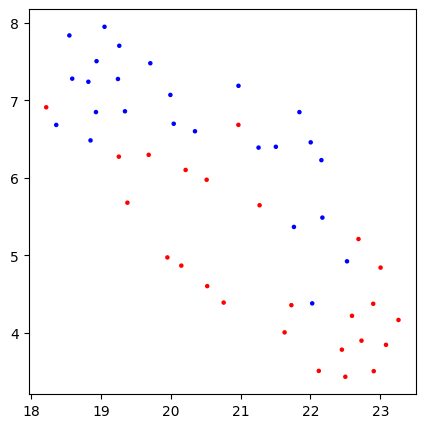

In [17]:
GW_dist_mat = compute_in_parallel(proteins=base_prots, returning= True, comparison_method= GW_protein.run_GW)

run time = 33.33891153335571
Silhouette Score: 0.05910659167377886
Davies-Bouldin Score: 3.415350027048936


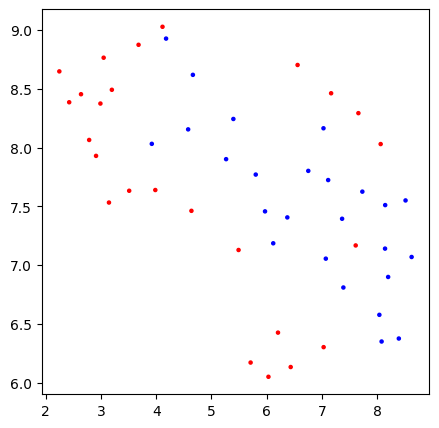

In [13]:
compute_in_parallel(proteins=downsamped_100_prots, comparison_method= GW_protein.run_GW)

run time = 28.42481780052185
Silhouette Score: 0.06301721163567767
Davies-Bouldin Score: 3.3344688254720225


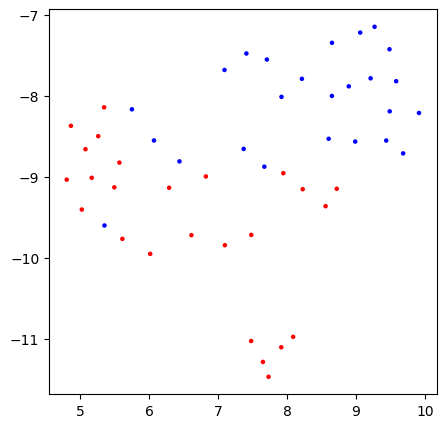

In [14]:
compute_in_parallel(proteins=downsampled_then_scaled_prots, comparison_method= GW_protein.run_GW)

In [15]:
# compute GW with cells
cells = [p.make_GW_cell() for p in base_prots]

run time = 423.40787053108215
Silhouette Score: 0.07693604174946868
Davies-Bouldin Score: 3.135804477816036


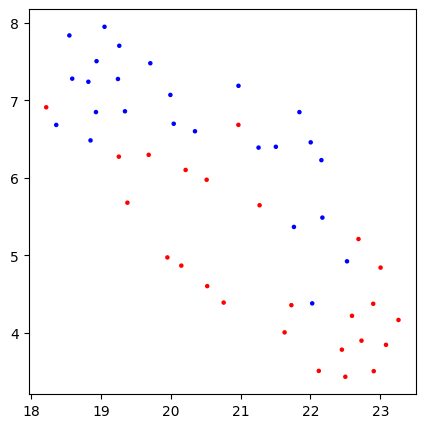

In [18]:
GW_cells_dist_mat = compute_in_parallel(cells, GW_protein.run_GW_from_cells, returning =True)
assert np.isclose(GW_cells_dist_mat, GW_dist_mat).all()


In [38]:
import GWProt.FGW_matrices

In [ ]:
from GWProt.FGW_matrices import *

compute_in_parallel(proteins=base_prots, comparison_method=GW_protein.run_FGW_dict, alpha = 0.05,d = get_BLOSUM_dict(n = 62))

We also demonstrate using user-inputted data:

In [ ]:
eccentricity_lists = [p.get_eccentricity() for p in base_prots]
FGW_eccentricity_dist_mat = np.zeros((50,50))

start_time = time.time()
with multiprocess.Pool() as pool:
    results = pool.imap(lambda pair: (pair[0], pair[1], GW_protein.run_FGW_data_lists(base_prots[pair[0]], 
                                                                                 base_prots[pair[1]], 
                                                                                 data1 = eccentricity_lists[pair[0]],
                                                                                data2 = eccentricity_lists[pair[1]],
                                                                                      alpha = 0.05)), it.combinations(range(50),2))
    for r in results:
        i,j,d = r
        FGW_eccentricity_dist_mat[i,j] = d
        FGW_eccentricity_dist_mat[j,i] = d
run_time = time.time() - start_time

In [ ]:
display(FGW_eccentricity_dist_mat)


In [ ]:

# GW_protein_pI

base_prots_pI = [GW_protein_pI.make_protein_from_pdb(file) for file in decoys + rdrps]

# cast to GW_protein and show they're equal
assert base_prots == [p.GW_protein() for p in base_prots_pI]

# compute FGW
# sequence based-downsampling
# uniform downsampling

In [ ]:
compute_in_parallel(proteins=base_prots_pI, comparison_method= GW_protein_pI.run_FGW, alpha = 0.05)

In [ ]:
FGW_downsampled = [p.downsample_n(100) for p in base_prots_pI]

In [ ]:
compute_in_parallel(proteins=FGW_downsampled, comparison_method= GW_protein_pI.run_FGW, alpha = 0.05)

In [ ]:
compute_in_parallel(proteins=base_prots_pI, comparison_method= GW_protein_pI.run_FGW_seq_aln, alpha = 1)

In [ ]:
compute_in_parallel(proteins=base_prots_pI, comparison_method= GW_protein_pI.run_FGW_seq_aln, alpha = 0.05)

In [ ]:
%%time
FGW_pI_dist_mat = np.zeros((50,50))

with multiprocess.Pool() as pool:
    results = pool.imap(lambda pair: (pair[0], pair[1], GW_protein_pI.run_FGW(base_prots_pI[pair[0]], base_prots_pI[pair[1]], alpha = 0.5, )), it.combinations(range(50),2))

    # results = pool.imap(lambda pair: (pair[0], pair[1], GW_protein.run_FGW_dict(base_prots[pair[0]], base_prots[pair[1]], alpha = 0.5,d = hydrophobicity_dict )), it.combinations(range(50),2))
    for r in results:
        i,j,d = r
        FGW_pI_dist_mat[i,j] = d
        FGW_pI_dist_mat[j,i] = d


In [ ]:
display_clustering(FGW_pI_dist_mat)
show_silhouette_score(FGW_pI_dist_mat)
show_davies_bouldin_score(FGW_pI_dist_mat)

In [ ]:
%%time
FGW_pI_downsampled_dist_mat = np.zeros((50,50))

with multiprocess.Pool() as pool:
    results = pool.imap(lambda pair: (pair[0], pair[1], GW_protein_pI.run_FGW(FGW_downsampled[pair[0]], FGW_downsampled[pair[1]], alpha = 0.5, )), it.combinations(range(50),2))

    for r in results:
        i,j,d = r
        FGW_pI_downsampled_dist_mat[i,j] = d
        FGW_pI_downsampled_dist_mat[j,i] = d


In [ ]:
display_clustering(FGW_pI_downsampled_dist_mat)
show_silhouette_score(FGW_pI_downsampled_dist_mat)
show_davies_bouldin_score(FGW_pI_downsampled_dist_mat)

In [ ]:
%%time
GW_seq_dist_mat = np.zeros((50,50))

with multiprocess.Pool() as pool:
    results = pool.imap(lambda pair: (pair[0], pair[1], GW_protein_pI.run_FGW_seq_aln(base_prots_pI[pair[0]], base_prots_pI[pair[1]], alpha = 1, )), it.combinations(range(50),2))

    for r in results:
        i,j,d = r
        GW_seq_dist_mat[i,j] = d
        GW_seq_dist_mat[j,i] = d




In [ ]:
display_clustering(GW_seq_dist_mat)
show_silhouette_score(GW_seq_dist_mat)
show_davies_bouldin_score(GW_seq_dist_mat)

In [ ]:
%%time
FGW_seq_dist_mat = np.zeros((50,50))

with multiprocess.Pool() as pool:
    results = pool.imap(lambda pair: (pair[0], pair[1], GW_protein_pI.run_FGW_seq_aln(FGW_downsampled[pair[0]], FGW_downsampled[pair[1]], alpha = 0.5, )), it.combinations(range(50),2))

    for r in results:
        i,j,d = r
        FGW_seq_dist_mat[i,j] = d
        FGW_seq_dist_mat[j,i] = d




In [ ]:
display_clustering(FGW_seq_dist_mat)
show_silhouette_score(FGW_seq_dist_mat)
show_davies_bouldin_score(FGW_seq_dist_mat)